# Perceptron Model (Scratch)

For this section of the project we will train & test a Percepton model made from scratch using the `Perceptron` class provided by the book *Machine Learning with PyTorch and Scikit-Learn* by Sebastian Rashka, Yuxi (Hayden) Liu, & Vahid Mirjalili. I will modify the code for the UCI Adult Income dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from itertools import product

In [2]:
class Perceptron:
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1]) # initialize weights from a normal distribution (decision is arbitrary)
        # Use this instead of zero because the learning rate (eta) would have no affect on the weights if they are all initialized to zero
        # we are just interested in small random values to avoid the properties of all-zero vectors

        # if you use libarry versions stated by book use float_, else if new use float64
        # self.b_ = np.float_(0.)
        self.b_ = np.float64(0.)
        
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)


---

## Reload Preprocessed Data Created in *01_preprocess.ipynb*

Our data has already been processed, so all we have to do is relead it into this notebook. 

In [3]:
# Reload features
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test  = pd.read_csv("../data/processed/X_test.csv")

# Reload targets (squeezed into Series)
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze("columns")
y_test  = pd.read_csv("../data/processed/y_test.csv").squeeze("columns")

# Align test columns to train columns (critical)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

We have to convert our data to numpy (`PerceptronScratch` loops over rows; keep types simple)

In [4]:
Xtr = X_train.to_numpy(dtype=np.float64, copy=False)
Xte = X_test.to_numpy(dtype=np.float64, copy=False)
ytr = y_train.to_numpy(dtype=np.int64, copy=False)
yte = y_test.to_numpy(dtype=np.int64, copy=False)

---

## Train the Scratch Perceptron Model

- **Cross-validation on training only**: We score each `(eta, n_iter)` combo with 3-fold StratifiedKFold using only `X_train, y_train`. No peeking at test.

- **Pick best hyperparams**: Choose the pair with the highest mean CV accuracy (tie-break on smaller `n_iter`).

- **Final training**: Retrain a Perceptron on the full training set using the chosen hyperparams.

- **Single test evaluation**: Report accuracy, confusion matrix, and classification report on the held-out test set.

- **Convergence plot**: Show misclassifications per epoch (`errors_`) for the final model.

| Note: We are not touching `X_val` here. Save that for the final, overall best model across all families.

In [5]:
# CV helper (no test set touched here) 
def cv_mean_accuracy(eta, n_iter, X, y, n_splits=3, seed=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    scores = []
    for tr_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X[tr_idx], X[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]
        model = Perceptron(eta=eta, n_iter=n_iter, random_state=seed)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        scores.append(accuracy_score(y_val, preds))
    return float(np.mean(scores))

In [6]:
# Small, fast grid over (eta, n_iter) 
eta_grid    = [0.001, 0.005, 0.01, 0.05]        # trim for speed; widen later if needed
n_iter_grid = [25, 50, 100, 150]

best = {"eta": None, "n_iter": None, "cv_acc": -1.0}

for eta, n_iter in product(eta_grid, n_iter_grid):
    cv_acc = cv_mean_accuracy(eta, n_iter, Xtr, ytr, n_splits=3, seed=42)
    if (cv_acc > best["cv_acc"]) or (
        cv_acc == best["cv_acc"] and (n_iter < (best["n_iter"] or 10))
    ):
        best.update({"eta": eta, "n_iter": n_iter, "cv_acc": cv_acc})

print(f"Selected by CV → eta={best['eta']}, n_iter={best['n_iter']}, "
      f"mean CV acc={best['cv_acc']:.4f}")

Selected by CV → eta=0.05, n_iter=25, mean CV acc=0.8273


In [7]:
# Train final model on ALL training data with best params
final = Perceptron(eta=best["eta"], n_iter=best["n_iter"], random_state=42)
final.fit(Xtr, ytr)

# Single evaluation on the held-out TEST set 
y_pred = final.predict(Xte)
acc = accuracy_score(yte, y_pred)
print(f"\nFINAL on TEST — Accuracy: {acc:.4f}")
print("Confusion Matrix:\n", confusion_matrix(yte, y_pred))
print("\nClassification Report:\n", classification_report(yte, y_pred, digits=4))


FINAL on TEST — Accuracy: 0.7875
Confusion Matrix:
 [[4705 1229]
 [ 432 1449]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9159    0.7929    0.8500      5934
           1     0.5411    0.7703    0.6357      1881

    accuracy                         0.7875      7815
   macro avg     0.7285    0.7816    0.7428      7815
weighted avg     0.8257    0.7875    0.7984      7815



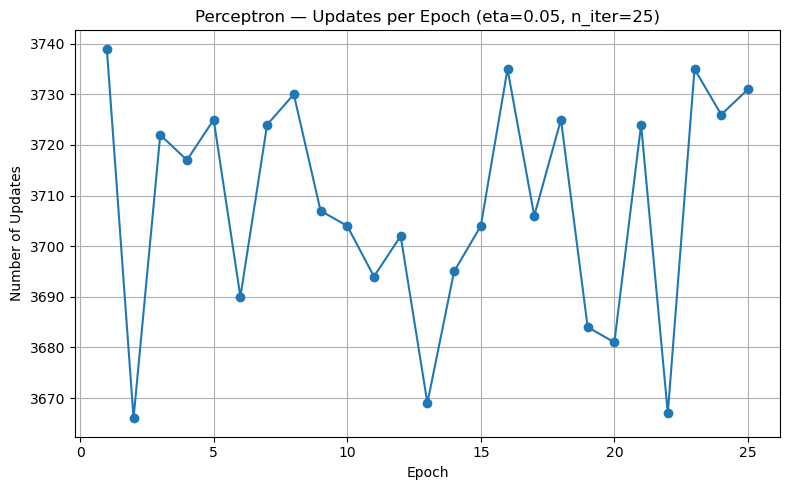

In [13]:
# Plot training misclassifications per epoch for the final model 
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(final.errors_) + 1), final.errors_, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Number of Updates")
plt.title(f"Perceptron — Updates per Epoch (eta={best['eta']}, n_iter={best['n_iter']})")
plt.grid(True)

# Save into outputs/graphs folder
plt.tight_layout()
plt.savefig("../outputs/graphs/perceptron_updates-per-epoch.png")

# Display as well
plt.show()

---

## Final Report
Cross-validation selected a Perceptron with `eta=0.05` and `n_iter=25` (CV accuracy ≈ 0.83). On the held-out test set it reached 78.75% accuracy, with strong performance on class 0 but lower precision for class 1, though recall for class 1 was relatively high (77%).